# Overview
This file contains a basic exploration of the dataset as well as some preprocessing for the features. It modifies the dataset and pickles a new version, so it is necessary to be run prior to any of the classifer notebooks. 

In [39]:
from ExploratoryFunctions import *

import seaborn as sns
import scipy.stats as stats
import os

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
data_dir = 'SavedData'

In [5]:
data = pd.read_csv(os.path.join(data_dir, 'merged_labeled_data.csv'))
data.uids = data.uids.apply(eval)

In [6]:
data.columns

Index(['engagement', 'procedural', 'procedural_question', 'question',
       'weak_question', 'topic_intro', 'uids_str', 'committee_position',
       'committee_position_next', 'committee_position_prev', 'pid', 'pid_next',
       'pid_prev', 'simple_label', 'simple_label_next', 'simple_label_prev',
       'text', 'text_next', 'text_prev', 'uid_next', 'uid_prev', 'uids',
       'vid'],
      dtype='object')

### Defining my classes
After looking over all of the utterances I realized I wanted to simplifiy my labels to two cases. 
1. The utterance implies the legislator is engaging with a witness or the bill author in a way that adds to the discussion.
    * engagement
    * question
2. The utterance is just part of legislative procedure. 
    * procedural
    * procedural_question

I'll combine these into my two classes.

In [7]:
data['label'] = data.apply(lambda row: get_classes(row), axis=1)
# Not totally sure why, but some classifiers need this
data['binary_label'] = [0 if lab == 'procedural' else 1 for lab in data.label]

Okay let's checkout the break down of the classes

In [8]:
data.label.value_counts()

engagement    135
procedural     95
Name: label, dtype: int64

In [9]:
# A nested dictionary containing lists of all the features columns names in the "data" dataframe
features_dict = {}

### Examining Context
I already filtered to include only utterances that I thought would be likely to indicate engagement. However, logically the committee position and category of the speaker as well as those preceding and suceeding the speaker might still be important in determining the label.

In [11]:
# From ExploratoryFunctions
context_features

['committee_position_prev',
 'committee_position',
 'committee_position_next',
 'simple_label_prev',
 'simple_label',
 'simple_label_next']

I'll use a Chi-Square test to examine how well these variables define differences between my classes

In [12]:
scores = {}
for feat in context_features:
    # Creates my contigency table
    counts = pd.crosstab(data[feat], data.label)
    X_sq, p_val, df, expected = stats.chi2_contingency(observed= counts)
    scores[feat] = X_sq
    print('Feature:', feat, '\n')
    print('Value Counts:\n', data[feat].value_counts(), '\n')
    print('Test Stat:', X_sq, 'P-Val:', p_val, '\n')
    print('=========================================')

Feature: committee_position_prev 

Value Counts:
 Not In Committee    80
Member              77
Chair               57
Possible Chair       8
Vice-Chair           7
Co-Chair             1
Name: committee_position_prev, dtype: int64 

Test Stat: 30.4961721822 P-Val: 1.17763969646e-05 

Feature: committee_position 

Value Counts:
 Member                 159
Not In Committee        37
Vice-Chair              18
Possible Chair          15
Possible Vice-Chair      1
Name: committee_position, dtype: int64 

Test Stat: 2.89604378736 P-Val: 0.575370219385 

Feature: committee_position_next 

Value Counts:
 Not In Committee    199
Member               30
Chair                 1
Name: committee_position_next, dtype: int64 

Test Stat: 12.2854114628 P-Val: 0.0021491008548 

Feature: simple_label_prev 

Value Counts:
 Legislator          161
General Public       33
Bill Author          16
State Agency Rep     11
LAO                   4
Unlabeled             3
Lobbyist              2
Name: simple_l

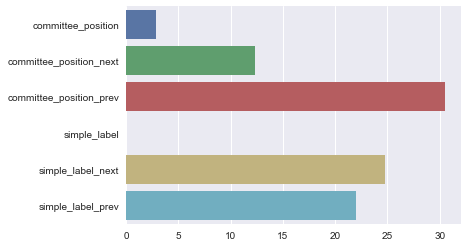

In [13]:
scores = pd.Series(scores)
ax = sns.barplot(x=scores.values, y=scores.keys())

Most features have really high test statistics indicating that they are not independent of my classes. "simple_label" is obviously 0 because it is always legislator. 

In [14]:
# Hot encoding for 'context' features
d = {}
features_dict['context_features'] = d
for feat in context_features:
    dummies = pd.get_dummies(data[feat])
    dummies.columns = [feat + '_' + col for col in dummies]
    
    d[feat] = list(dummies.columns)
    data = pd.concat([data, dummies], axis=1)
    

### Engineered Features
Before moving on to text based features, I want to create a couple of features based around the length of the interaction to help separate the classes. Typically engagement interactions are longer than procedural ones, so it seems reasonable that this might help.  

In [15]:
data['word_count'] = data.text.apply(lambda t: len(word_tokenize(t)))
data['prev_word_count'] = data.text_prev.apply(lambda t: len(word_tokenize(t)))
data['next_word_count'] = data.text_next.apply(lambda t: len(word_tokenize(t)))

data['uid_count'] = data.uids.apply(len)
data['?_count'] = data.text.apply(lambda t: t.count('?'))
# Ratio of question marks to total words
data['?_ratio'] = data['?_count'] / data.word_count

In [16]:
eng_features

['word_count',
 'prev_word_count',
 'next_word_count',
 'uid_count',
 '?_count',
 '?_ratio']

In [17]:
scores = {}
for feat in eng_features:
    a = data.loc[data.label == 'engagement', feat]
    b = data.loc[data.label == 'procedural', feat]
    
    t, p_val = stats.ttest_ind(a, b, equal_var=False)
    scores[feat] = t
    
    print('Feature:', feat, '\n')
    print('Test Stat:', t, 'P-Val:', p_val, '\n')
    print('=========================================')

Feature: word_count 

Test Stat: 5.61807504198 P-Val: 9.01963727698e-08 

Feature: prev_word_count 

Test Stat: -0.440936126263 P-Val: 0.659736396099 

Feature: next_word_count 

Test Stat: 1.41475813732 P-Val: 0.158657475061 

Feature: uid_count 

Test Stat: 2.28476038465 P-Val: 0.0232868332849 

Feature: ?_count 

Test Stat: 5.44428738205 P-Val: 1.34400447224e-07 

Feature: ?_ratio 

Test Stat: -1.16110998676 P-Val: 0.247970973467 



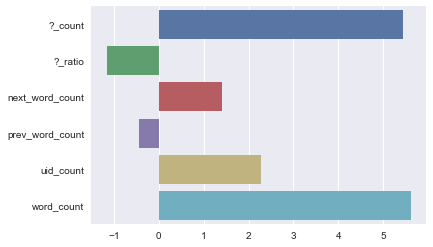

In [18]:
scores = pd.Series(scores)
ax = sns.barplot(x=scores.values, y=scores.keys())

Hmm, I definitely want to retain word count and "?" count in the final model and I'll probably ignore the others. 

In [19]:
features_dict['eng_features'] = eng_features

### Text Features
All text feature preprocessing is handled by TFIDF vectorizer in the classifier pipeline. However, there was one exception. 

Basically all question words are stop-words, so I thought it might be useful to have a separate way to compute these. I want to single these out in particular because they often times signal engagement.

In [20]:
# from wikipedia
interrogative_words

{'how',
 'what',
 'when',
 'whence',
 'where',
 'whether',
 'which',
 'whither',
 'who',
 'whom',
 'whose',
 'why'}

In [23]:
for feat in text_features:
    feat = 'q_' + feat
    data[feat] = data.text.apply(only_q_words, interrogative_words=interrogative_words)
    

**Note:** I ended up not using these because instead of filtering out stopwords directly I just set a maximum document frequency. However I left this piece in in case a future user might want to go this route

## Examining Parse Trees with Stanford Core NLP

#### Parse Tree Node Counts (Syntactic Tags)

For reference:
<img src='tag_names.png'>

**Note** For this next line of code to work you need to download Stanford Core NLP be running the server locally. 
[Instructions](https://stanfordnlp.github.io/CoreNLP/corenlp-server.html#getting-started)

In [34]:
nlp = StanfordCoreNLP('http://localhost:9000')

### Parse Trees

When I first did some Googling for this problem I found [this](https://stackoverflow.com/questions/17879551/nltk-find-if-a-sentence-is-in-a-questioning-form) post on SO which suggests matching the sentence to a generic parse tree with the format of a question. This works pretty well for simple questions. 

In [35]:
q = "What is the capital of Scotland?"
print_parse_tree(q, nlp)

(ROOT
  (SBARQ
    (WHNP (WP What))
    (SQ (VBZ is)
      (NP
        (NP (DT the) (NN capital))
        (PP (IN of)
          (NP (NNP Scotland)))))
    (. ?)))


But for actual examples spoken by legislators, it pretty quickly become clear this isn't going to work. 

In [36]:
q = """One is how, I think it was already answered, I was going to ask you why do need a statewide goal if water agencies are all ready using desal as an option?"""
print_parse_tree(q, nlp)

(ROOT
  (S
    (S
      (NP (CD One))
      (VP (VBZ is)
        (SBAR
          (WHADVP (WRB how))
          (, ,)
          (S
            (NP (PRP I))
            (VP (VBP think)
              (SBAR
                (S
                  (NP (PRP it))
                  (VP (VBD was)
                    (VP
                      (ADVP (RB already))
                      (VBN answered))))))))))
    (, ,)
    (NP (PRP I))
    (VP (VBD was)
      (VP (VBG going)
        (S
          (VP (TO to)
            (VP (VB ask)
              (NP (PRP you))
              (SBAR
                (WHADVP (WRB why))
                (S
                  (VP (VBP do)
                    (VP (VB need)
                      (NP (DT a) (JJ statewide) (NN goal))
                      (SBAR (IN if)
                        (S
                          (NP (NN water) (NNS agencies))
                          (VP (VBP are)
                            (ADVP (DT all))
                            (ADJP (JJ ready)
  

It becomes clear that matching specific types of senteces, such as questions isn't really feasible. However, it occurred to me that I could simply treat these syntax tags in the same way the bag of words approach looks at text. Instead I'll build a classifier with "bag of syntax tags". This makes sense because engaging utterances will often times use specific tags more than procedural. 

In [37]:
# I need to combine my parse tree so that it looks like a sentence
syntactic_targets = set(['ADJP',
                         'ADVP',
                         'NP', 
                         'PP', 
                         'S', 
                         'SBAR', 
                         'SBARQ', 
                         'SINV', 
                         'SQ',
                         'VP', 
                         'WHADVP', 
                         'WHNP', 
                         'WHPP'])

In [40]:
data['syn_tags'] = data.text.apply(stanford_parse, nlp=nlp, syntactic_targets=syntactic_targets)

The processed data and features dictionary are pickled for other notebooks. 

In [43]:
pickle.dump(data, open(os.path.join(data_dir, 'processed_data.pkl'), 'wb'))
pickle.dump(features_dict, open(os.path.join(data_dir, 'features_dict.pkl'), 'wb'))